In [41]:
from datasets import load_dataset
emotions = load_dataset("emotion")

In [42]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [5]:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


This is optional / dont run this as it breaks training stuff further down below

In [7]:
import pandas as pd

emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [8]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


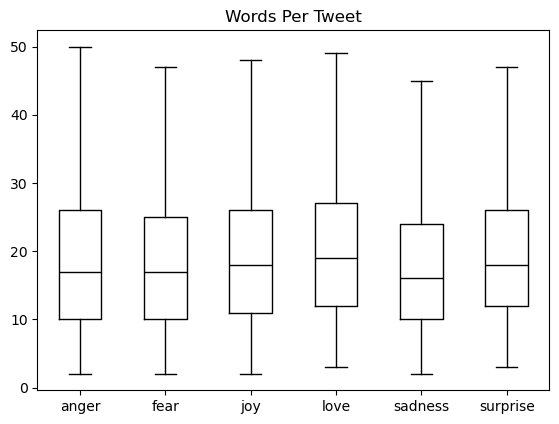

In [9]:
import matplotlib.pyplot as plt
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
          showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

Here the normal stuff continues

In [50]:
emotions.reset_format()

In [51]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [52]:
encoded_text = tokenizer("Tokenizing text is a core task of NLP.")
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [53]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


In [54]:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [55]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [56]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

In [57]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [58]:
emotions_encoded.set_format("torch", 
                            columns=["input_ids", "attention_mask", "label"])

In [59]:
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [60]:
emotions_hidden["train"].column_names

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']

In [61]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

In [62]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

LogisticRegression(max_iter=3000)

I'm not sure what I can do with all this...

In [67]:
text = "I am angry"
inputs = tokenizer(text, return_tensors="pt")
inputs

{'input_ids': tensor([[ 101, 1045, 2572, 4854,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [69]:
inputs.map(extract_hidden_states)

AttributeError: 